# Anomaly detection for Dispatch cold room

In [1]:
# import libraries
import sys
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# config plots
%matplotlib inline
sns.set(rc={"figure.figsize": (26, 10)})

In [2]:
# load custom functions
sys.path.append("../")
from cnrdlib import cl_eda as cle

In [3]:
# load 5-min data from data-etl
engine = create_engine(f"sqlite:///../data/RawData.db")
df_all = pd.read_sql_table("SensorData_5min", con=engine, index_col="timestamp")
df_all.head()

WIP_temp   DP_temp   Ext_temp  WIP_current  DP_current
timestamp                                                                  
2021-03-30 00:00:00  4.828750  3.028125  17.063750     5.881250    9.741250
2021-03-30 00:05:00  4.299444  3.080000  17.474444     6.122778    9.839444
2021-03-30 00:10:00  4.506471  2.900588  17.605882     5.895000    9.783750
2021-03-30 00:15:00  4.075000  3.020000  17.395000     5.597059    9.704118
2021-03-30 00:20:00  4.044118  3.010000  17.536471     5.254118    8.987647

In [4]:
df_all.columns

Index(['WIP_temp', 'DP_temp', 'Ext_temp', 'WIP_current', 'DP_current'], dtype='object')

In [5]:
# keep only cold room temperature column
df = df_all.drop(['WIP_temp', 'Ext_temp', 'WIP_current', 'DP_current'], axis=1)
df.head()

DP_temp
timestamp                    
2021-03-30 00:00:00  3.028125
2021-03-30 00:05:00  3.080000
2021-03-30 00:10:00  2.900588
2021-03-30 00:15:00  3.020000
2021-03-30 00:20:00  3.010000

In [6]:
# plot timeseries data to identify a training period
cle.plot_timeseries_plotly(df, ["DP_temp"])

In [7]:
# select time period to find a "normal" patterns
filter_5min = (df.index > '2021-05-07 16:30') & (df.index < '2021-05-11 4:20')
sns.lineplot(x=df.index[filter_5min], y="DP_temp", data=df[filter_5min], label="5min");

In [8]:
filter_cycle = (df.index > '2021-05-07 22:20') & (df.index < '2021-05-08 4:35')
sns.lineplot(x=df.index[filter_cycle], y="DP_temp", data=df[filter_cycle], label="5min");

In [9]:
len(df[filter_cycle])

74

In [10]:
# Normalize and save the mean and std we get,
# for normalizing test data.
df_train = df[filter_5min]
training_mean = df_train.mean()
training_std = df_train.std()
df_training_value = (df_train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 1005


In [11]:
TIME_STEPS = 76

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (930, 76, 1)


MSE was chosen as the loss function to benefit of penalising larger errors which can be critical for this application.

In [12]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.1),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.1),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 38, 32)            256       
_________________________________________________________________
dropout (Dropout)            (None, 38, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 38, 16)            1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 76, 32)            3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 76, 1)             2

In [13]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/100
7/7 [==============================] - 1s 38ms/step - loss: 0.9135 - val_loss: 0.8737
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6505 - val_loss: 0.5062
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.3187 - val_loss: 0.2371
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 0.1673 - val_loss: 0.1683
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1567 - val_loss: 0.1482
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1360 - val_loss: 0.1618
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 0.1298 - val_loss: 0.1401
Epoch 8/100
7/7 [==============================] - 0s 15ms/step - loss: 0.1198 - val_loss: 0.1249
Epoch 9/100
7/7 [==============================] - 0s 15ms/step - loss: 0.1115 - val_loss: 0.1128
Epoch 10/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1073 - val_loss: 0.1116
Epoch 11/100
7/7 [=

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

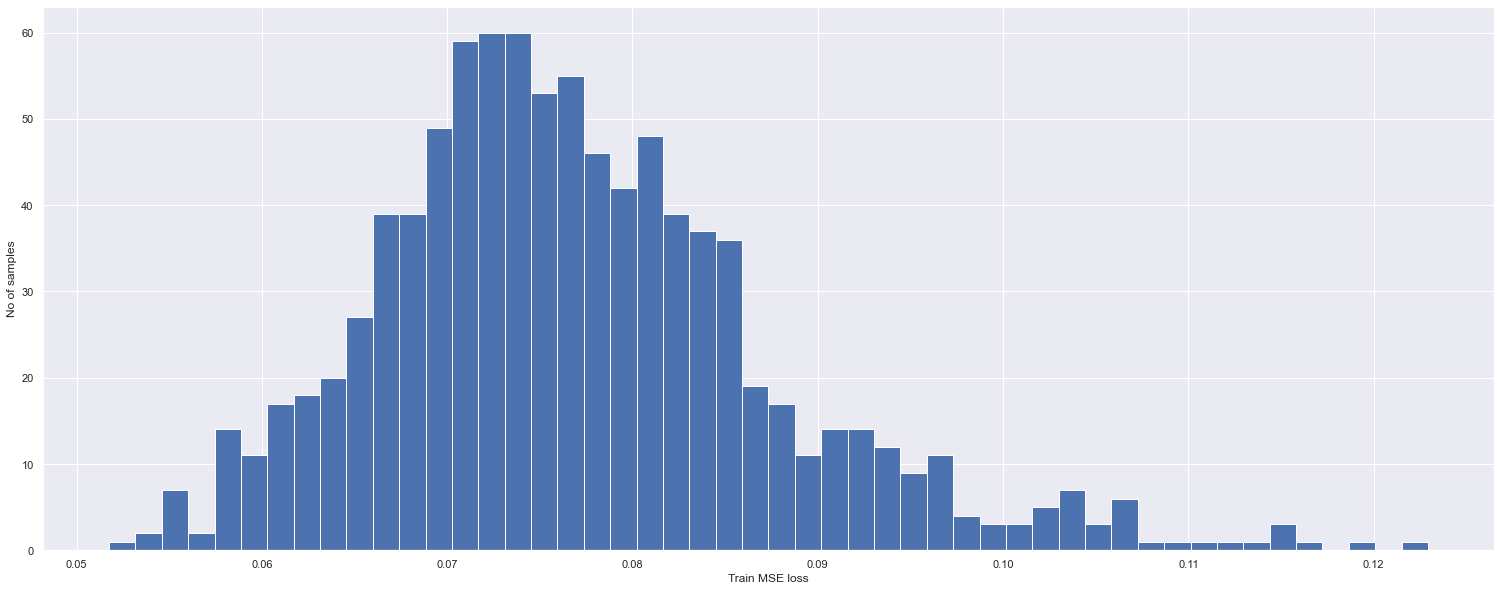

Reconstruction error threshold:  0.12292883760130711


In [31]:
# Get train MSE loss.
x_train_pred = model.predict(x_train)
train_mse_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mse_loss, bins=50)
plt.xlabel("Train MSE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mse_loss)
print("Reconstruction error threshold: ", threshold)

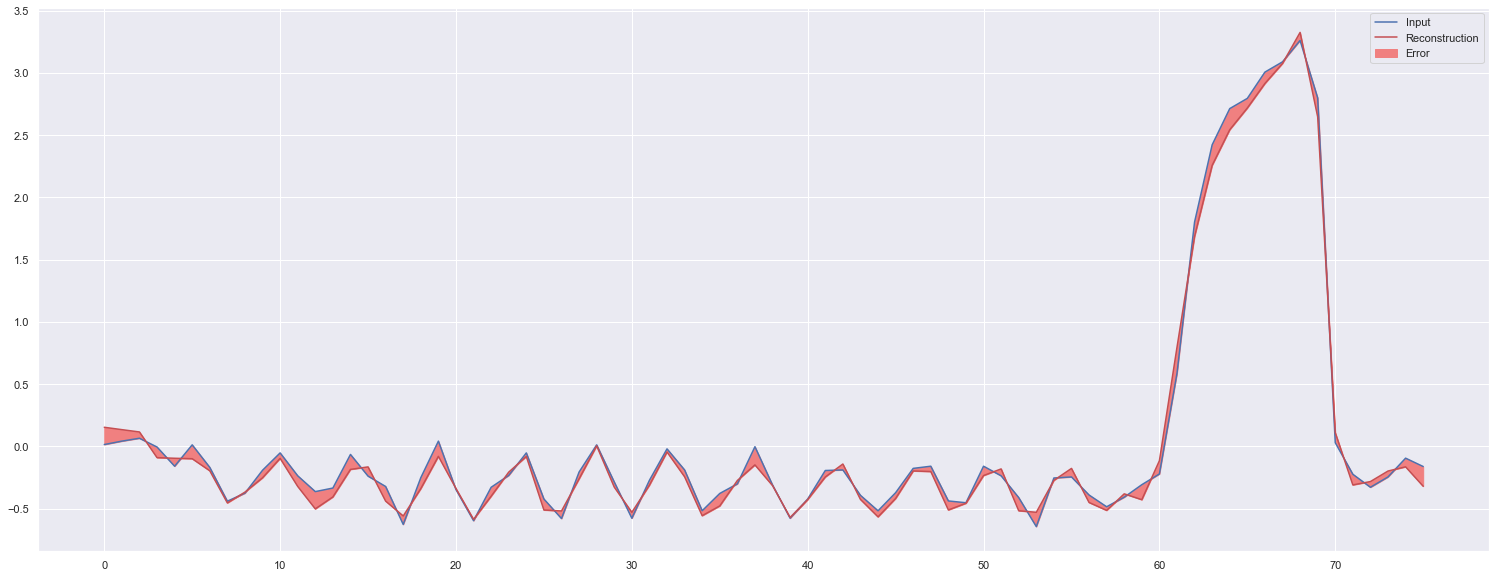

In [16]:
cle.plot_anomaly(0, TIME_STEPS, x_train, x_train_pred)

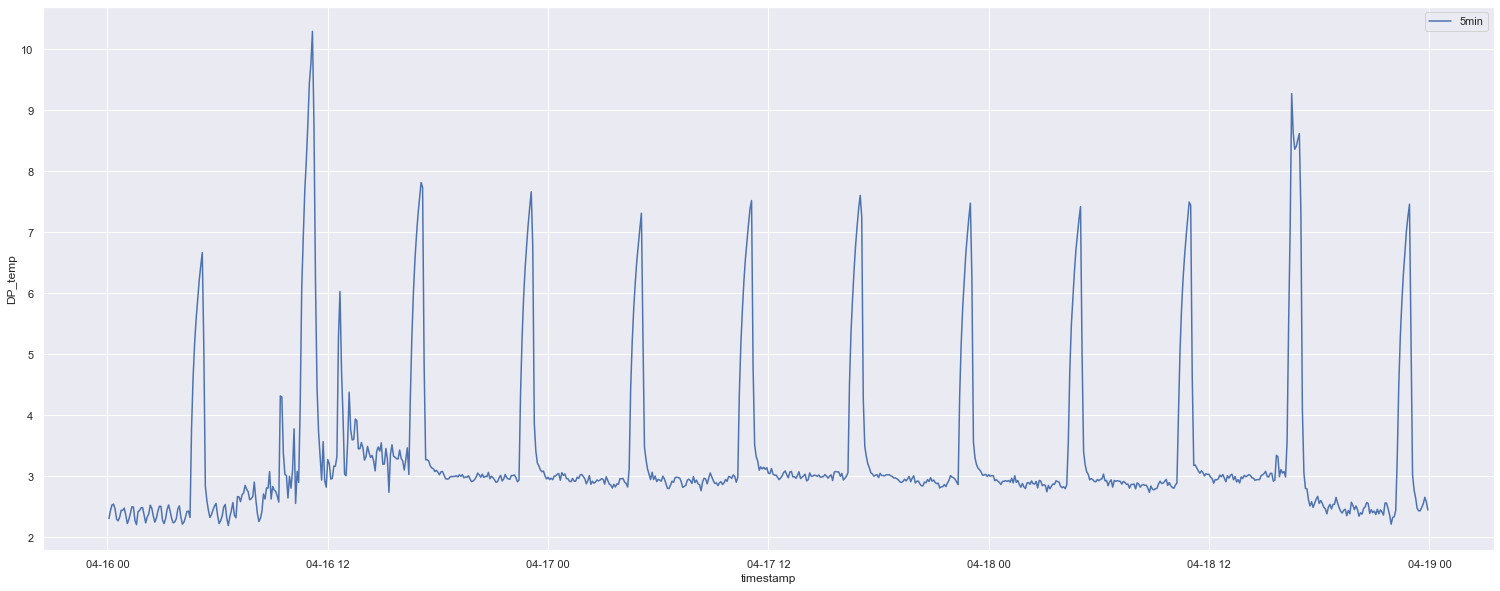

In [17]:
filter_anomaly = (df.index > '2021-04-16') & (df.index < '2021-04-19')
sns.lineplot(x=df.index[filter_anomaly], y="DP_temp", data=df[filter_anomaly], label="5min");

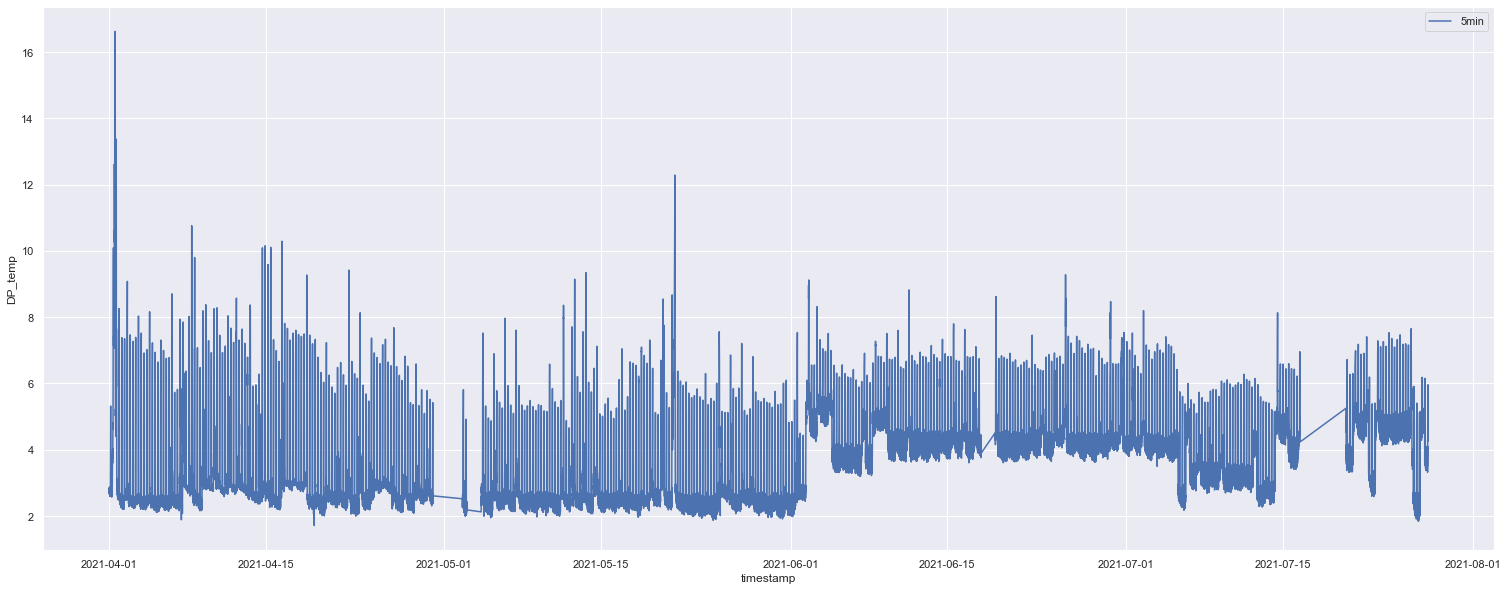

In [79]:
filter_anomaly = (df.index > '2021-04-01') & (df.index < '2021-07-30')
sns.lineplot(x=df.index[filter_anomaly], y="DP_temp", data=df[filter_anomaly], label="5min");

In [18]:
df_anomaly = df[filter_anomaly]
df_anomaly.head()

DP_temp
timestamp                    
2021-04-16 00:05:00  2.304118
2021-04-16 00:10:00  2.433750
2021-04-16 00:15:00  2.525882
2021-04-16 00:20:00  2.539375
2021-04-16 00:25:00  2.460588

Test input shape:  (788, 76, 1)


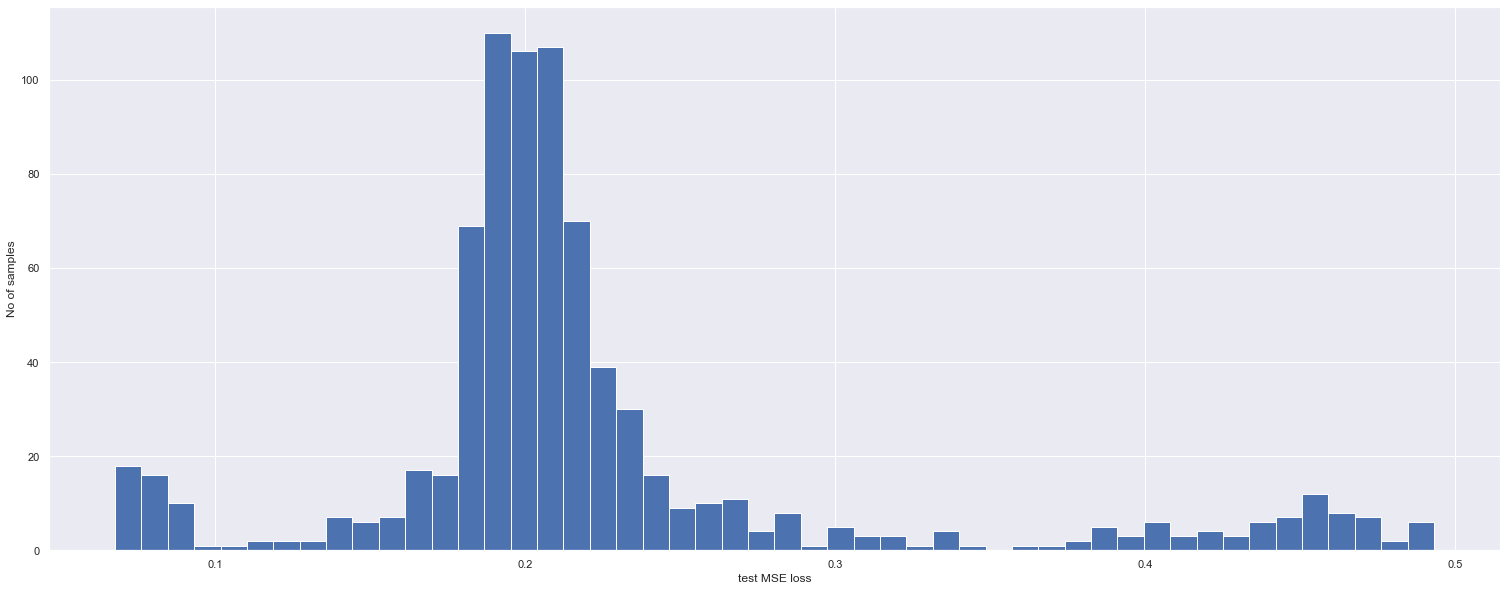

Number of anomaly samples:  738


In [32]:
df_test_value = (df_anomaly - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MSE loss.
x_test_pred = model.predict(x_test)
test_mse_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mse_loss = test_mse_loss.reshape((-1))

plt.hist(test_mse_loss, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mse_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
#print("Indices of anomaly samples: ", np.where(anomalies))

In [27]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [28]:
df_subset = df_anomaly.iloc[anomalous_data_indices]
df_subset.shape

(661, 1)

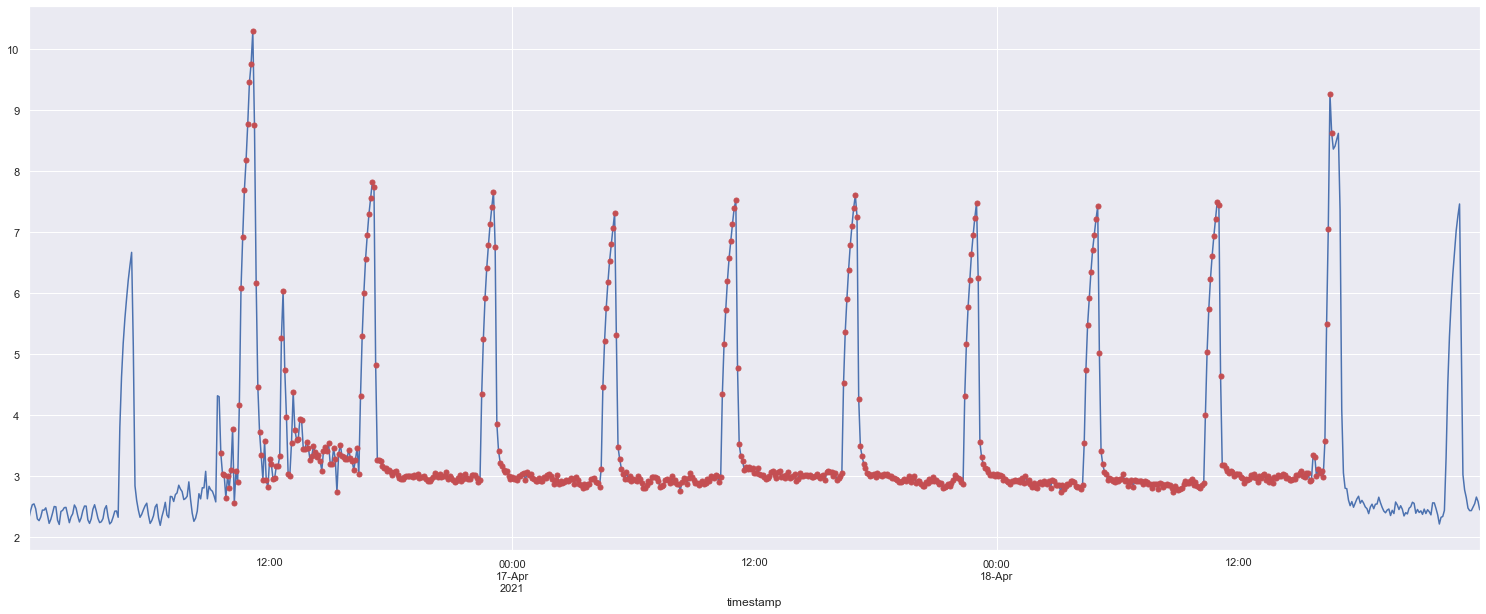

In [29]:
fig, ax = plt.subplots()
df_anomaly.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r", marker="o", markersize=5, linewidth=0)
plt.show()

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_anomaly.index, y=df_anomaly.DP_temp, mode='lines', name='trend'))
fig.add_trace(go.Scatter(x=df_subset.index, y=df_subset.DP_temp, mode='markers', name='anomalies'))
fig.show()

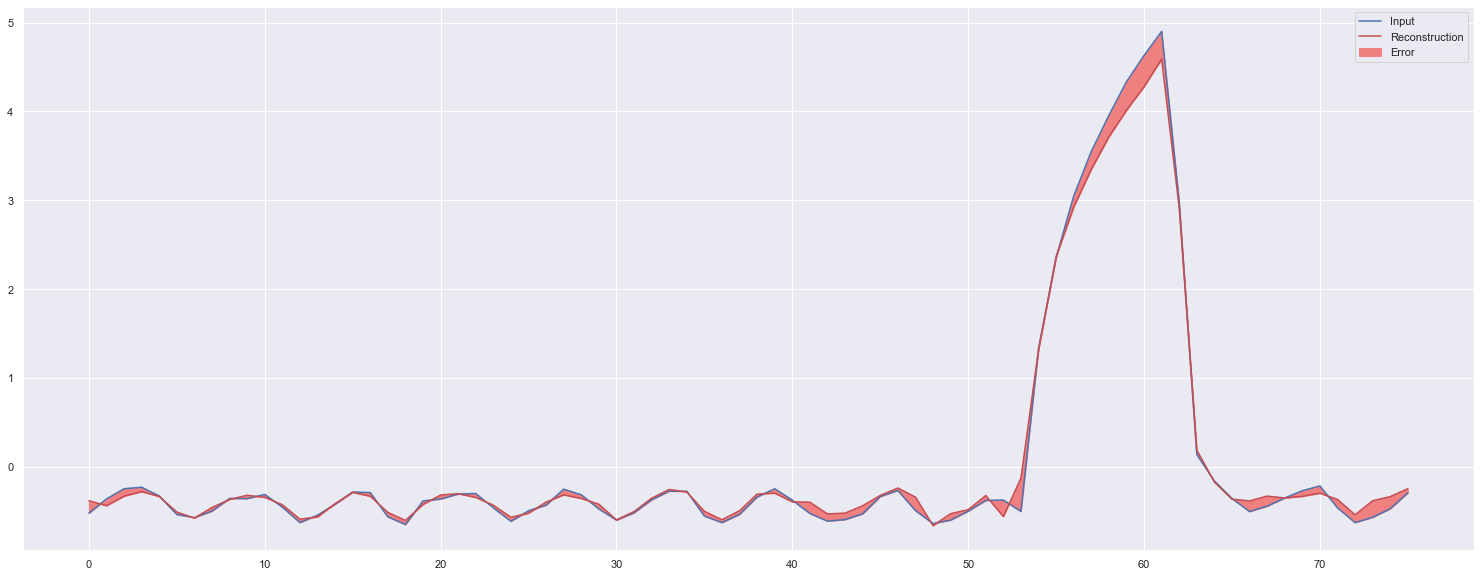

In [22]:
cle.plot_anomaly(0, TIME_STEPS, x_test, x_test_pred)

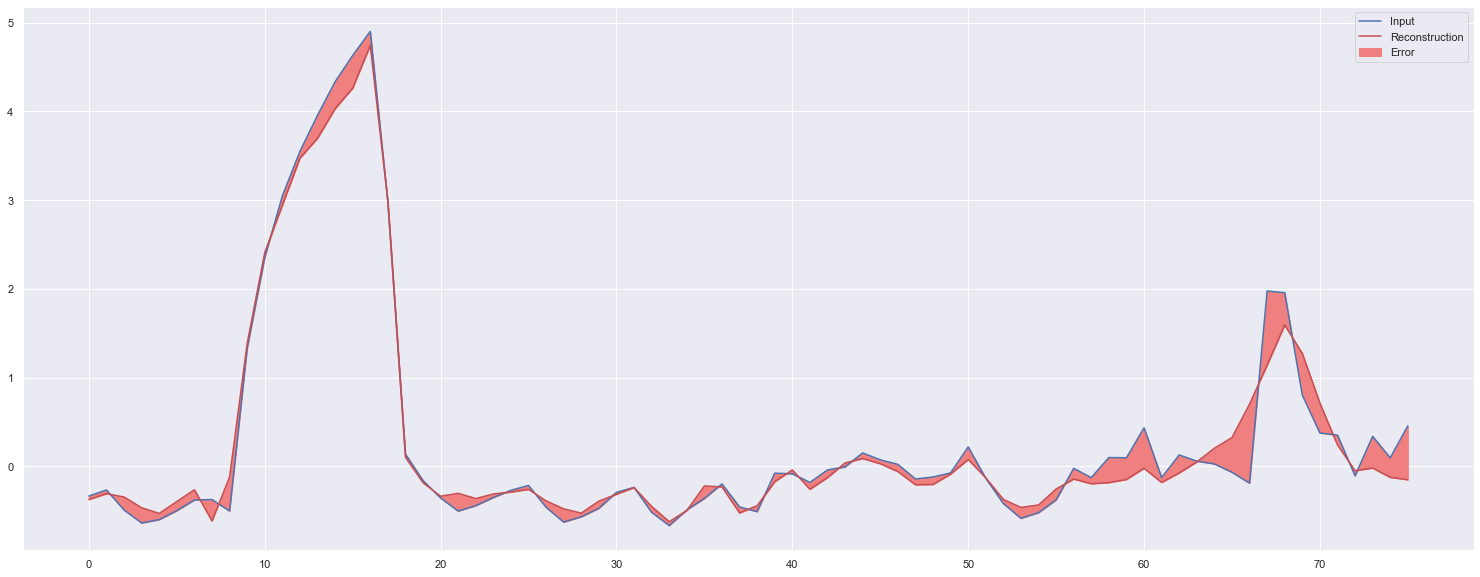

In [23]:
cle.plot_anomaly(45, TIME_STEPS, x_test, x_test_pred)

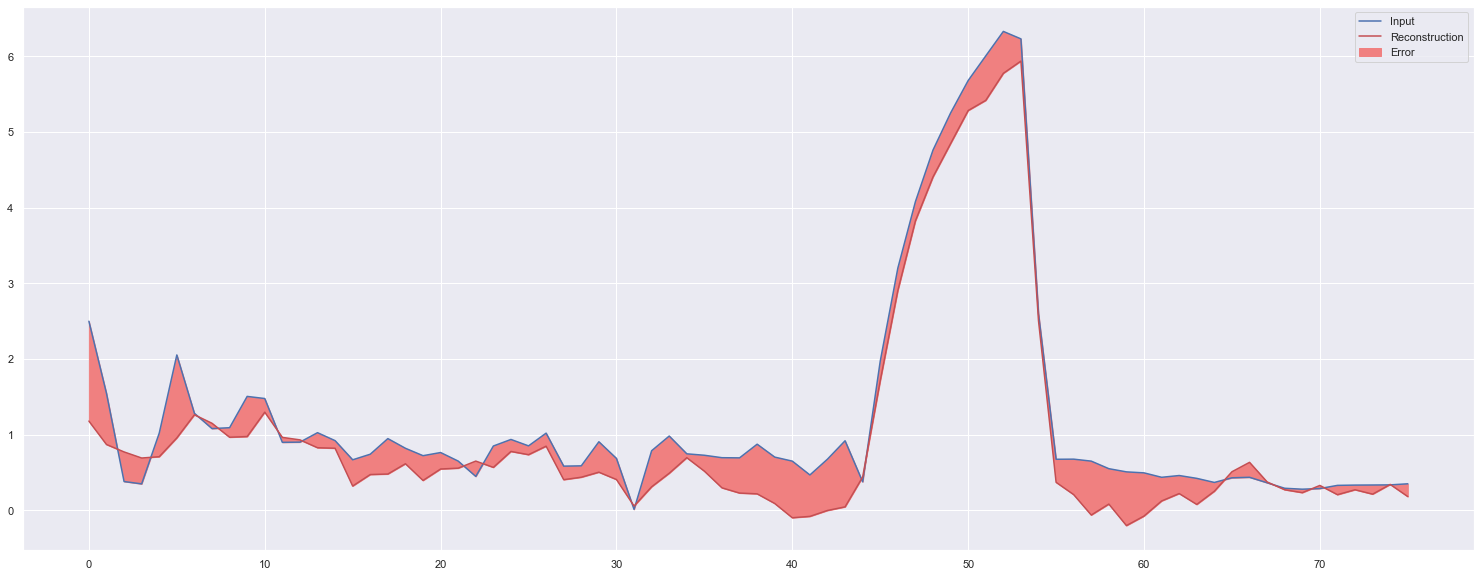

In [24]:
cle.plot_anomaly(76*2, TIME_STEPS, x_test, x_test_pred)

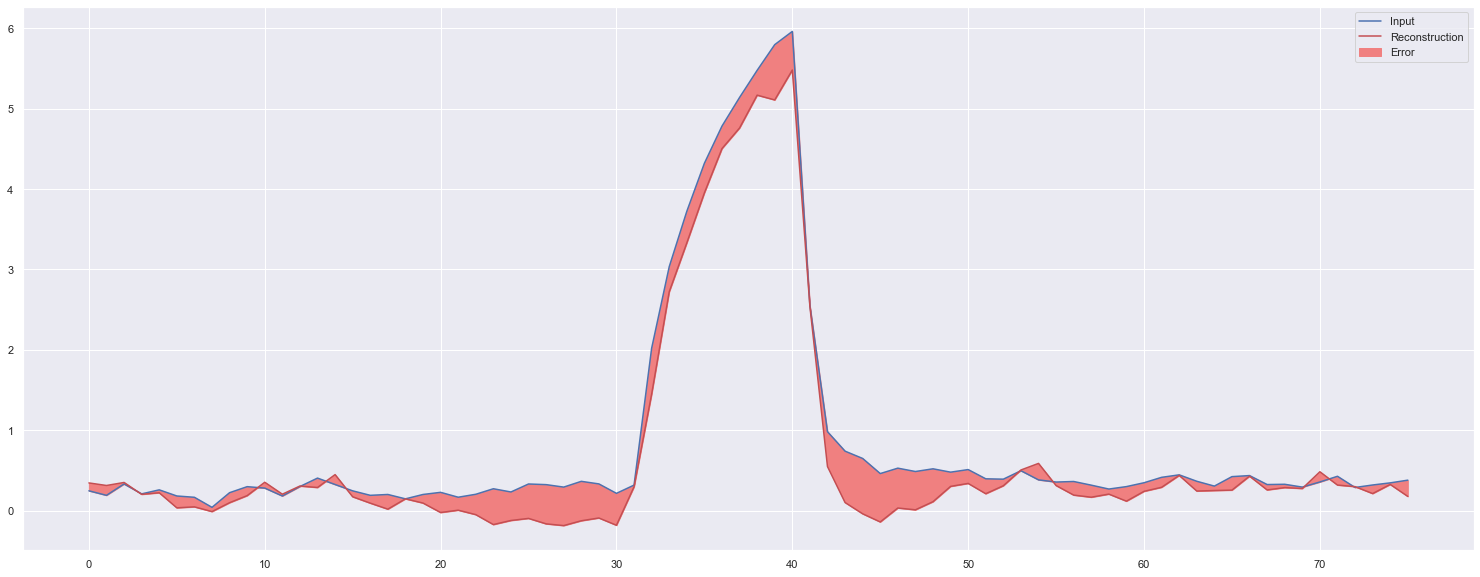

In [25]:
cle.plot_anomaly(76*5, TIME_STEPS, x_test, x_test_pred)

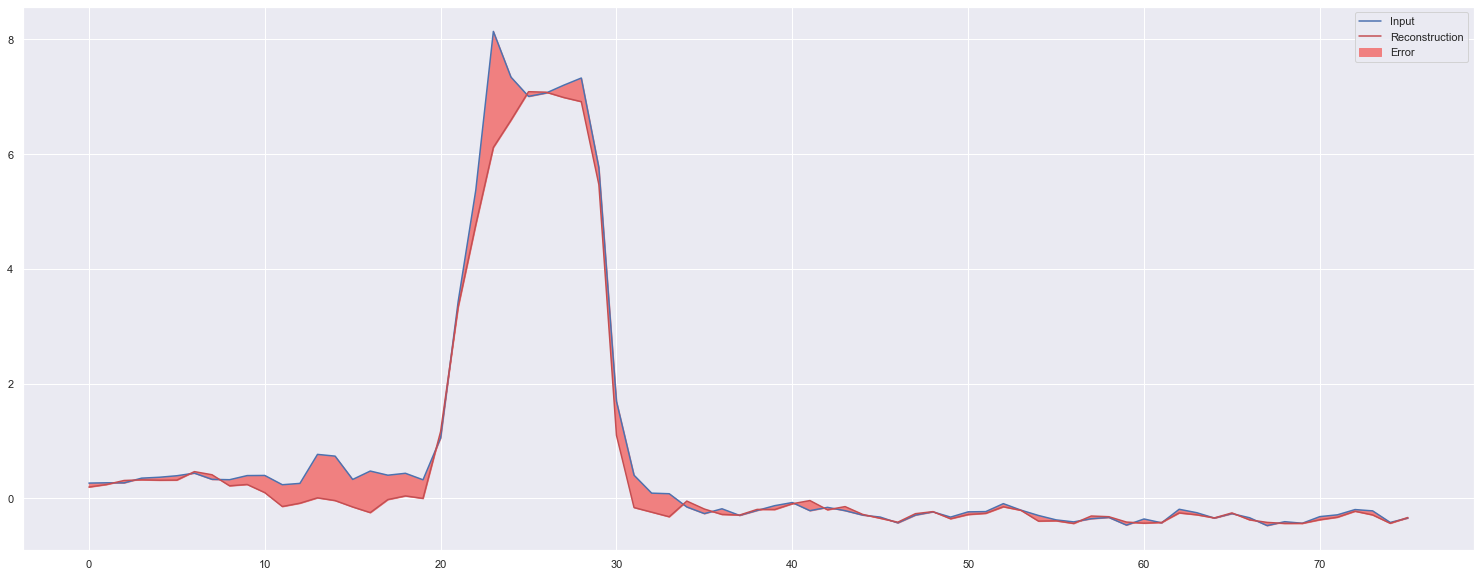

In [26]:
cle.plot_anomaly(750, TIME_STEPS, x_test, x_test_pred)